In [7]:
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import community as community_louvain
import matplotlib.pyplot as plt #For plotting graphs
import igraph as ig
import numpy as np
import leidenalg as la
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    f1_score,
    confusion_matrix,
)
from collections import Counter
from networkx.algorithms.community import label_propagation_communities
from cdlib import algorithms

from modularitydensity.metrics import modularity_density
import community as louvain
import leidenalg as la
from cdlib.algorithms import louvain

from cdlib import evaluation

import os

import random


np.random.seed(42)  # Imposta il seed per NumPy
random.seed(42)

# Login dataset

In [8]:
# Percorso del file GML
file_path = "C:/Users/lulyd/Downloads/as.gml"

# Leggi il grafo dal file GML
G = nx.read_gml(file_path)

# Variabile globale per memorizzare le comunità di ground truth
communities_dict = {}

# Itera su tutti i nodi del grafo
for node in G.nodes(data=True):
    node_id = node[0]   # id del nodo
    gt_value = node[1].get('gt')  # il valore di ground truth (gt)

    # Aggiungi il nodo alla comunità corrispondente
    if gt_value in communities_dict:
        communities_dict[gt_value].append(node_id)
    else:
        communities_dict[gt_value] = [node_id]

# Stampa le comunità
for gt, nodes in communities_dict.items():
    print(f"Comunità con gt={gt}: {nodes}")

# Ottieni i valori gt per colorare i nodi
gt_values = nx.get_node_attributes(G, 'gt')

# Crea una mappa di colori basata sui membri della comunità
color_map = []
for node in G.nodes():
    # Assegna un ID di comunità a ciascun nodo
    found = False
    for department, members in communities_dict.items():
        if node in members:
            color_map.append(department)  # Colore della comunità
            found = True
            break
    if not found:
        color_map.append('lightgray')  # Colore per nodi non appartenenti a nessuna comunità


Comunità con gt=8: ['3', '291', '18', '24', '1280', '10490', '27', '6059', '32', '34', '715', '7091', '50', '57', '217', '6263', '7430', '11680', '19647', '81', '5778', '6389', '7938', '11426', '11442', '13371', '14448', '19718', '27446', '32417', '33401', '36850', '91', '3754', '101', '73', '103', '160', '237', '293', '683', '1224', '1785', '1982', '2152', '2153', '2544', '2899', '3401', '3428', '3699', '3701', '3742', '3807', '4261', '4544', '4565', '5650', '5663', '6182', '6295', '6325', '6360', '6366', '7774', '7782', '7941', '7968', '8047', '10430', '10587', '10594', '10609', '10835', '10838', '11038', '11164', '11274', '11303', '11404', '11608', '11726', '11808', '11837', '11922', '11995', '12111', '12168', '12284', '13331', '13476', '13680', '13692', '13776', '14041', '14678', '14744', '14954', '15065', '15105', '15307', '16509', '16586', '16713', '17184', '17200', '17293', '18530', '19029', '19092', '19518', '19782', '20130', '21519', '21640', '21947', '22059', '22212', '23265'

In [9]:
def calcola_metriche(comunita_attese, comunita_rilevate, adjacency_matrix):
    # Creazione della mappatura dei nodi a indici
    nodi = []
    for community in comunita_attese.values():
        nodi.extend(community)
    nodo_to_index = {nodo: idx for idx, nodo in enumerate(nodi)}

    # Preparazione dei dati per ARI e NMI
    true_labels = np.zeros(len(nodi), dtype=int)  # Etichette vere
    for community_id, community_nodes in comunita_attese.items():
        for node in community_nodes:
            true_labels[nodo_to_index[node]] = int(community_id[-1])  # Usa l'ID della comunità

    predicted_labels = np.full(len(nodi), -1)  # Valori non assegnati    
    for cluster_id, nodes in comunita_rilevate.items():
        for node in nodes:
            if node in nodo_to_index:  # Assicurati che il nodo esista nella mappatura
                predicted_labels[nodo_to_index[node]] = int(cluster_id)  # Usa l'ID della comunità

# Calcolo delle metriche
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    # Calcolo dell'HS
    hs = homogeneity_score(true_labels, predicted_labels)

    # Calcolo del CS
    cs = completeness_score(true_labels, predicted_labels)

    # Calcolo della F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcolo della Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Calcolo della Modularity Density
    md = modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Score
    cs_score = community_score(adjacency_matrix, comunita_rilevate, nodo_to_index)

    # Calcolo della Community Fitness
    fitness = community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index)


    # Stampa dei risultati
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
    print(f"Homogeneity Score (HS): {hs:.4f}")
    print(f"Completeness Score (CS): {cs:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Modularity Density: {md:.4f}")
    print(f"Community Score: {cs_score:.4f}")
    print(f"Community Fitness: {fitness:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Risultati da visualizzare
    metriche = {
        'ARI': ari,
        'AMI': ami,
        'HS': hs,
        'CS': cs,
        'F1 Score': f1,
        'Modularity Density': md,
        'Community Score': cs_score,
        'Community Fitness': fitness,
        'NMI': nmi
    }

    return metriche

    # Creazione del grafico a barre
    plt.figure(figsize=(10, 6))
    plt.bar(metriche.keys(), metriche.values(), color='skyblue')
    plt.ylabel('Valore')
    plt.title('Metriche di Rilevamento delle Comunità')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

 

    x = np.arange(len(labels))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, true_values, width=bar_width, label='Comunità Attese', color='skyblue')
    plt.bar(x + bar_width/2, predicted_values, width=bar_width, label='Comunità Rilevate', color='salmon')
    plt.xlabel('Comunità')
    plt.ylabel('Numero di Nodi')
    plt.title('Confronto tra Comunità Attese e Rilevate')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    
# Funzioni di supporto 
def modularity_density(adjacency_matrix, comunita_rilevate, nodo_to_index):
    k = len(comunita_rilevate)  # Numero di comunità
    densita = 0.0  # Inizializza la densità a zero

    for community in comunita_rilevate.values():
        V_c = len(community)  # Numero di nodi nella comunità
        E_c = 0  # Inizializza il conteggio degli archi nella comunità

        # Calcola il numero di archi tra i nodi nella comunità
        for i in range(V_c):
            for j in range(i + 1, V_c):  # Evita il conteggio doppio
                idx_i = nodo_to_index[community[i]]
                idx_j = nodo_to_index[community[j]]
                if adjacency_matrix[idx_i, idx_j] > 0:
                    E_c += 1

        # Calcola la densità della comunità
        if V_c > 1:  # Evita divisioni per zero
            densita += E_c / (V_c * (V_c - 1))

    # Calcola la densità modulare finale
    if k > 0:  # Evita divisioni per zero
        densita_modulare = densita / k
    else:
        densita_modulare = 0

    return densita_modulare

def community_score(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    total_edges = 0
    num_nodes = adjacency_matrix.shape[0]

    for community in comunita_rilevate.values():
        for i in range(len(community)):
            for j in range(i + 1, len(community)):  # Per evitare il conteggio doppio
                node_i = community[i]
                node_j = community[j]
                if adjacency_matrix[nodo_to_index[node_i], nodo_to_index[node_j]] > 0:
                    internal_edges += 1
    
    # Conta anche gli archi totali nel grafo
    total_edges = np.sum(adjacency_matrix) / 2  # Dato che è una matrice simmetrica

    if total_edges == 0:
        return 0  # Evita divisioni per zero
    return internal_edges / total_edges


def community_fitness(adjacency_matrix, comunita_rilevate, nodo_to_index):
    internal_edges = 0
    external_edges = 0
    num_nodes = adjacency_matrix.shape[0]  # Assicurati che la matrice sia quadrata

    node_to_community = {}
    for community_id, nodes in comunita_rilevate.items():
        for node in nodes:
            node_to_community[node] = community_id

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] > 0:  # Se esiste un arco
                node_i = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(i)]
                node_j = list(nodo_to_index.keys())[list(nodo_to_index.values()).index(j)]
                if node_to_community.get(node_i) == node_to_community.get(node_j):  # Se appartengono alla stessa comunità
                    internal_edges += 1
                else:
                    external_edges += 1

    total_edges = internal_edges + external_edges

    # Evita divisioni per zero
    if total_edges == 0:
        return 0

    return internal_edges / total_edges

# Label propagation

In [10]:
community_graph = nx.Graph() 
# Rilevamento delle comunità con l'algoritmo Label Propagation
communities= algorithms.label_propagation(G).communities
community_dict_label_propagation = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)


# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)



adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_label_propagation = calcola_metriche(communities_dict, community_dict_label_propagation, adj_matrix_full)

Community 1: ['11626', '2529', '41367', '43918', '18473', '30195', '43030', '37997', '13123', '11649', '30040', '7473', '21737', '14137', '3599', '40508', '12252', '30101', '29742', '44034', '16277', '10821', '3527', '44166', '46636', '29028', '3141', '30811', '31398', '39816', '42840', '4284', '41995', '22591', '28705', '37011', '8980', '5641', '29404', '31061', '31706', '16832', '19319', '9656', '48584', '29085', '20925', '19642', '39027', '38953', '29622', '36642', '11722', '24995', '14178', '18617', '23550', '43866', '20334', '40170', '46545', '1103', '14559', '35506', '32625', '43606', '42356', '23431', '17332', '32076', '12047', '33152', '30470', '27965', '34115', '25973', '6379', '27025', '24486', '19916', '30961', '19459', '21243', '40208', '28646', '11005', '16711', '47296', '22472', '1244', '27510', '29128', '46632', '21829', '22325', '46358', '32101', '4150', '16253', '14353', '24061', '17349', '25572', '17990', '44451', '8119', '1267', '10400', '15480', '38546', '1842', '31

# Louvain

In [11]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)
communities = algorithms.louvain(G).communities
community_dict_louvain = {i: community for i, community in enumerate(communities)}


for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_louvain = calcola_metriche(communities_dict, community_dict_louvain, adj_matrix_full)

Community 1: ['6079', '5778', '6389', '11426', '237', '1785', '4261', '4565', '7782', '10587', '17184', '17293', '19029', '23292', '701', '1239', '7018', '7132', '26449', '209', '545', '557', '773', '1312', '2933', '3770', '4307', '4569', '4581', '4963', '5056', '5661', '5704', '5742', '6062', '6078', '6128', '6349', '6367', '6496', '6536', '6580', '7013', '7843', '7868', '7956', '8001', '8011', '8180', '10692', '10796', '10823', '10912', '10970', '10993', '11100', '11114', '11160', '11320', '11524', '11545', '11624', '11782', '11817', '11852', '11879', '11884', '11914', '11955', '11975', '11981', '11992', '12129', '12214', '12238', '12260', '13407', '13446', '13490', '13517', '13536', '13549', '13576', '13649', '13711', '13794', '13853', '13871', '14006', '14025', '14081', '14093', '14150', '14230', '14652', '14751', '14755', '14832', '14989', '15320', '16409', '16423', '16467', '16469', '16617', '16645', '16810', '16812', '17054', '17060', '17088', '17227', '17248', '17369', '17387',

# Leiden

In [12]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)

communities = algorithms.leiden(G).communities
community_dict_leiden = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

#Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_leiden = calcola_metriche(communities_dict, community_dict_leiden, adj_matrix_full)


Community 1: ['715', '7091', '11680', '19647', '5778', '6389', '11426', '31919', '91', '3754', '1785', '2044', '2899', '4261', '4319', '4323', '4544', '4565', '5650', '6295', '6360', '7385', '7782', '10587', '10838', '11038', '11303', '12284', '13680', '13776', '15065', '15082', '16586', '17184', '17293', '19029', '21640', '22822', '23292', '23504', '25847', '46205', '701', '1239', '7018', '7132', '26449', '14', '209', '557', '773', '2033', '2379', '2711', '2828', '3356', '3561', '3770', '3820', '4232', '4355', '4436', '4581', '4943', '4965', '5006', '5056', '5738', '5742', '6062', '6122', '6128', '6189', '6300', '6349', '6367', '6428', '6496', '6536', '6580', '6597', '6983', '7151', '7238', '7796', '7819', '7843', '7922', '7956', '8001', '8011', '8015', '8148', '8180', '10242', '10439', '10565', '10692', '10796', '10823', '10912', '10970', '10993', '11057', '11100', '11114', '11168', '11169', '11236', '11320', '11393', '11396', '11398', '11427', '11430', '11457', '11524', '11545', '11

# Risultati

                    Label Propagation    Louvain     Leiden
ARI                          0.078400   0.158764   0.221056
AMI                          0.198283   0.301670   0.313268
HS                           0.264636   0.382108   0.383343
CS                           0.219469   0.251254   0.267221
F1 Score                     0.035789   0.105855   0.125543
Modularity Density           0.000579   0.000156   0.000392
Community Score              0.677697   0.140121   0.179632
Community Fitness            0.677697   0.140121   0.179632
NMI                          0.239945   0.303163   0.314918
Numero di Comunità         725.000000  27.000000  29.000000


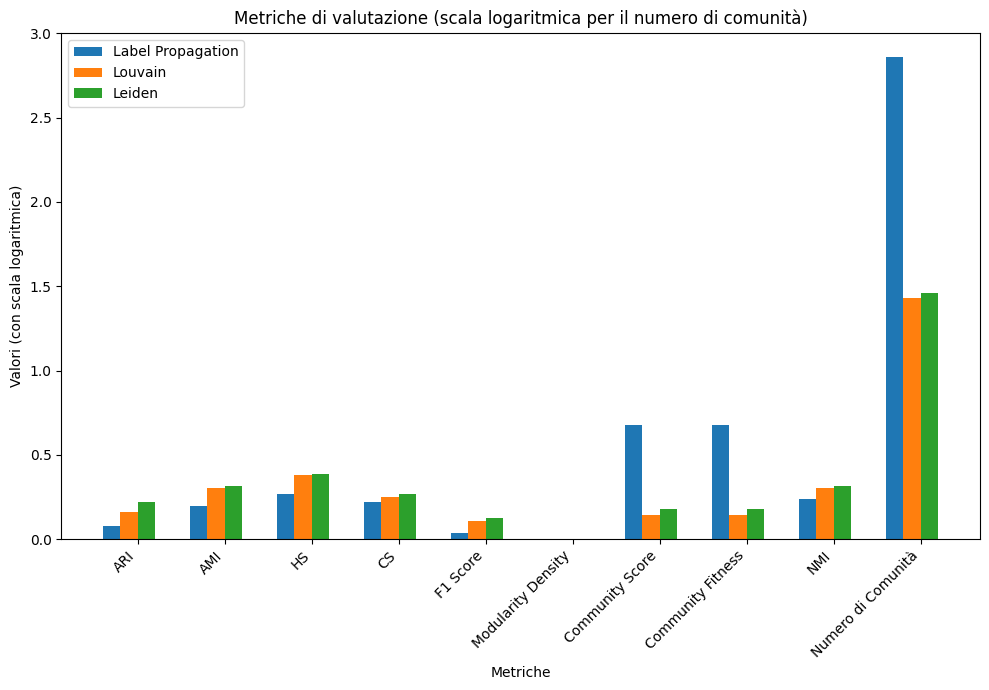

In [16]:

risultati = {
    "Label Propagation": {**risultati_label_propagation, "Numero di Comunità": len(community_dict_label_propagation)},
    "Louvain": {**risultati_louvain, "Numero di Comunità": len(community_dict_louvain)},
    "Leiden": {**risultati_leiden, "Numero di Comunità": len(community_dict_leiden)},
}

# Creazione di un DataFrame dalle metriche ottenute per ogni algoritmo, inclusi il numero di comunità
df_risultati = pd.DataFrame(risultati)

# Visualizzazione del DataFrame per vedere i risultati
print(df_risultati)

# Applicare la scala logaritmica al numero di comunità
df_risultati_log = df_risultati.copy()
df_risultati_log.loc["Numero di Comunità"] = np.log10(df_risultati_log.loc["Numero di Comunità"])

# Impostare dimensioni della figura per il grafico
fig, ax = plt.subplots(figsize=(10, 7))

# Definire le posizioni delle barre
n_misure = len(df_risultati_log.index)
bar_width = 0.2
index = np.arange(n_misure)

# Plot delle barre con scala logaritmica
for i, algoritmo in enumerate(df_risultati_log.columns):
    ax.bar(index + i * bar_width, df_risultati_log[algoritmo], bar_width, label=algoritmo)

# Aggiungere etichette e titolo
ax.set_xlabel('Metriche')
ax.set_ylabel('Valori (con scala logaritmica)')
ax.set_title('Metriche di valutazione (scala logaritmica per il numero di comunità)')

# Configurazione delle etichette per l'asse X
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(df_risultati_log.index, rotation=45, ha='right')

# Aggiungere legenda
ax.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()

# Conga tempo di implementazione dell'algoritmo troppo elevato (400min)

In [14]:
# Run the CONGA algorithm
com = algorithms.conga(G, number_communities=170)
community_dict = {i: community for i, community in enumerate(com.communities)}

# Print the detected communities
print("Communities detected:")
for i, community in enumerate(com.communities):
    print(f"Communità {i + 1}: {community}")


# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_conga = calcola_metriche(communities_dict, community_dict, adj_matrix_full)

KeyboardInterrupt: 